In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/researchPaperAssignment/models/inception

/content/drive/MyDrive/researchPaperAssignment/models/inception


In [3]:
!pip install -q pyyaml h5py

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle
import os

import sys
sys.path.append(os.path.join('..', '..'))

from global_params import *

In [5]:
batch_size = 200

In [ ]:
!unzip ../../data/train.zip
!unzip ../../data/test.zip

In [6]:
train_path = os.path.join('train')

train_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    # rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
).flow_from_directory(
    train_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 6352 images belonging to 901 classes.


In [51]:
#Checkpoint
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_freq=5*31)

logger_callback = tf.keras.callbacks.CSVLogger("history3.csv", append=True)

In [27]:
# Callback for early stopping
# es_callback = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.0001,
#     patience=5,
#     restore_best_weights=True
# )

In [52]:
# Hyperparameters
epochs = 5
learning_rate = 0.05
# lr_schedule = keras.optimizers.schedules.ExponentialDecay( initial_learning_rate=0.03, decay_steps=10000, decay_rate=0.9)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=6, verbose=1, mode='auto')

# Math works out so that one epoch equals one pass through the training data.
train_steps_per_epoch = train_batches.n // batch_size

In [29]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.stack.imgur.com/iNy2U.png")
#Image shows max pooling but the paper and this code implements L2 norm pooling

In [30]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [31]:
# define model input
input = keras.layers.Input(shape=input_shape)

conv1 = keras.layers.Conv2D(64, (7,7), activation='relu', strides=(2,2), padding='same', name='conv1')(input)
maxpool1 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1')(conv1)
norm1 = keras.layers.BatchNormalization(name='norm1')(maxpool1)

# add inception block 2
conv2_1 = keras.layers.Conv2D(64, (1,1), activation='relu', strides=(1,1), padding='same', name='conv2_1')(norm1)
conv2_3 = keras.layers.Conv2D(192, (3,3), activation='relu', strides=(1,1), padding='same', name='conv2_3')(conv2_1)
norm2 = keras.layers.BatchNormalization(name='norm2')(conv2_3)
maxpool2 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool2')(norm2)

# add inception block 3a
inception3a = inception_module(maxpool2, 64, 96, 128, 16, 32, 32)

# add inception block 3b
inception3b = inception_module(inception3a, 64, 96, 128, 32, 64, 64)

# add inception block 3c
conv3_3c = keras.layers.Conv2D(128, (1,1), padding='same', activation='relu')(inception3b)
conv3_3c = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu')(conv3_3c)
# 5x5 conv
conv5_3c = keras.layers.Conv2D(32, (1,1), padding='same', activation='relu')(inception3b)
conv5_3c = keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same', activation='relu')(conv5_3c)
# 3x3 max pooling
pool_3c = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(inception3b)
# concatenate filters, assumes filters/channels last
layer_out_3c = keras.layers.concatenate([conv3_3c, conv5_3c, pool_3c], axis=-1)

# add inception block 4a
inception4a = inception_module(layer_out_3c, 256, 96, 192, 32, 64, 128)

# add inception block 4b
inception4b = inception_module(inception4a, 224, 112, 224, 32, 64, 128)

# add inception block 4c
inception4c = inception_module(inception4b, 192, 128, 256, 32, 64, 128)

# add inception block 4d
inception4d = inception_module(inception4c, 160, 144, 288, 32, 64, 128)

# add inception block 4e
conv3_4e = keras.layers.Conv2D(160, (1,1), padding='same', activation='relu')(inception4d)
conv3_4e = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu')(conv3_4e)
# 5x5 conv
conv5_4e = keras.layers.Conv2D(64, (1,1), padding='same', activation='relu')(inception4d)
conv5_4e = keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same', activation='relu')(conv5_4e)
# 3x3 max pooling
pool_4e = keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(inception4d)
# concatenate filters, assumes filters/channels last
layer_out_4e = keras.layers.concatenate([conv3_4e, conv5_4e, pool_4e], axis=-1)

# add inception block 5a
inception5a = inception_module(layer_out_4e, 384, 192, 384, 48, 128, 128)

# add inception block 5b
inception5b = inception_module(inception5a, 384, 192, 384, 48, 128, 128)

# global average pooling layer
avgpool = keras.layers.GlobalAveragePooling2D()(inception5b)

# Flatten
# flat = keras.layers.Flatten(name='flatten')(avgpool)
drop = keras.layers.Dropout(0.2)(avgpool)
# dense fc layer
fc = keras.layers.Dense(128, name='fc1')(drop)
# L2 norm
l2norm = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='l2')(fc)

# create model
model = keras.Model(inputs=input, outputs=l2norm, name='NN2')

In [32]:
model.summary()

Model: "NN2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        input_3[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
norm1 (BatchNormalization)      (None, 24, 24, 64)   256         pool1[0][0]                      
________________________________________________________________________________________________

In [33]:
model.save_weights(checkpoint_path.format(epoch=0))

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2),
)

In [53]:
# %%script echo "Comment line with %%script echo to run this cell."

history = model.fit(
    train_batches,
    epochs=epochs,
    steps_per_epoch=train_steps_per_epoch,
    callbacks=[cp_callback, logger_callback, reduce_lr]
)

Epoch 1/5
31/31 [==============================] - 340s 11s/step - loss: 0.0484
Epoch 2/5
31/31 [==============================] - 363s 12s/step - loss: 0.0450
Epoch 3/5
31/31 [==============================] - 396s 13s/step - loss: 0.0446
Epoch 4/5
31/31 [==============================] - 362s 12s/step - loss: 0.0421
Epoch 5/5
30/31 [============================>.] - ETA: 10s - loss: 0.0428
Epoch 00005: saving model to training_2/cp-0005.ckpt
31/31 [==============================] - 329s 11s/step - loss: 0.0431


In [35]:
#get the latest checkpoint file
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [36]:
print(checkpoint_dir)

training_2


In [37]:
# Run model again
# Load the previously saved weights
model.load_weights(latest)

In [54]:
test_path = 'test'

test_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
).flow_from_directory(
    test_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 1254 images belonging to 901 classes.


In [55]:
# Evaluate the network
results = model.predict(test_batches)

In [56]:
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

x=np.concatenate([test_batches.next()[0] for i in range(test_batches.__len__())])
y=np.concatenate([test_batches.next()[1] for i in range(test_batches.__len__())])
print(x.shape)
print(y.shape)
y = y.astype(int)

import io

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, label in zip(x,y):
    [out_m.write(str(label) + "\n")]
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass


(1254, 96, 96, 1)
(1254,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# %%script echo "Comment line with %%script echo to run this cell."
model.save('best_inception_model.h5')

In [59]:
model = keras.models.load_model('best_inception_model.h5')

In [ ]:
import pandas as pd
df = pd.read_csv('history3.csv')

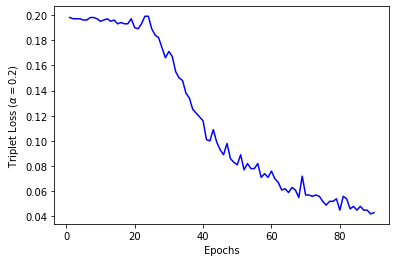

In [84]:
import matplotlib.pyplot as plt

plt.xlabel('Epochs')
plt.ylabel(r'Triplet Loss $(\alpha=0.2)$')
plt.plot(df['epoch'], df['loss'], color='b');